# Solving Partial Differential Equations Using Machine Learning and Parallelization

## Abstract

When solving partial differential equations, there is an infinite amount of freedom. One should try to project this infinite number of degrees of freedom to what is actually happening where there is a finite solution manifold. We are motivated by the difficulty of practically analyzing real-world phenomena, like the low resolution of a simulated hurricane weather model that is composed of big pixels, where each of them can only represent more than 100 square kilometers. We want to derive an update rule that depends only on the local part of the solution, replacing the differential operators with machine learning. The big picture is that, by maintaining locality, one can achieve generalizability. In particular, we will focus on numerical solutions for nonlinear PDEs with the primary target being Burger’s Equation. The equation has an exact solution, which will be compared to the numerical solution given by a neural network. The training process will return coefficients for spatial and time derivatives of the PDE, which will, in turn, be used to approximate the solution. 

## The mathematical problem and the equation

Considering the most general form of a PDE in a continous field <br>
$$
\frac{\partial v}{\partial t} = F(t, x, v, \frac{\partial v}{\partial x_i}, \frac{\partial v}{\partial x_i \partial y_i}, ...)
$$
<br>


A common algorithm to solve a PDE numerically is method of lines. For this method, we first use the spatial discretization 
$$
x_1, ... , x_N
$$ 
Then, we use values at node points (finite differences)
$$
v_i(t) = v(x_i, t)
$$ 
or its avaerages over a grid cell (finite volumnes)
$$
v_i(t) = \Delta x^{-1} \int_{x_i - \Delta x / 2 }^{x_i + \Delta x / 2} v (x', t)dx' 
$$ 
to represent the field of the PDE $v(x, t)$ where $\Delta x = x_i - x_{i-1}$ is the spacial resolution. <br>
Using various methods like spectral differentiation or polynomial expansion to approximate the spatial derivatives at the node points, we can compute the time evolution of $v_i$. This gives the formula 
$$
\frac{\partial^n v}{\partial v^n} \approx \sum_{i} \alpha_i^{(n)}v_i
$$
where $\alpha_i^{(n)}$ are precomputed coefficients. For example, the 1-dimensional finite-difference approximation for $\frac{\partial v}{\partial x}$ to first order accuracy is
$$
\partial v(x_i) = \frac{v_{i+1} - v_i}{\Delta x} + O(\Delta x)
$$
This discretization transforms the original PDE into a set of ODEs of the from
$$
\frac{\partial v_i}{\partial t} = F(t, x, v_1, ... , v_N)
$$


which can be numerically integrated. <br>
Currently, to resolve smaller-scale features of PDEs, solving practical problems like modeling turbulent fluid flow requires costly computational effort. The general practice is to replace the physical equations with effective equations that model the unresolved physics. These equations are then discretized and solved numerically using methods like the method of lines. Such a procedure modifies $\frac{\partial^n v}{\partial v^n} \approx \sum_{i} \alpha_i^{(n)}v_i$ by changing the $\alpha_i$ to account for the unresolved degrees of freedom, replacing the discrete equations in $\frac{\partial v_i}{\partial t} = F(t, x, v_1, ... , v_N)$ with a different set of discrete equations. <br>
However, we argue that we can model the unresolved physics by directly learning the data. Instead of deriving an approximate coarse-grained continuum model and discretizing it, directly learning low-resolution discrete models that encapsulate unresolved physics could give the desired results. Since it is mathematically true that the dimension of a solution manifold for a nonlinear PDE is finite, we can construct approximate parameterizations. If we knew the solution manifold, we can generate equation-specific approximations for the spatial derivatives in $\frac{\partial^n v}{\partial v^n} \approx \sum_{i} \alpha_i^{(n)}v_i$, which have the potential to hold even when the system is underresolved. In contrast to standard numerical methods, the coefficients $\alpha_i^{(n)}$ are equation dependent. Different regions in space will use different coefficients. To derive these formulas, we use machine learning. Firstly, we generate a training set of high-resolution data and then learn the discrete approximations to the derivatives in $\frac{\partial^n v}{\partial v^n} \approx \sum_{i} \alpha_i^{(n)}v_i$ from this dataset. This practice produces a tradeoff in computational cost, which can be alleviated by carrying out high-resolution simulations on small systems to develop local approximations to the solution manifold and using them to solve equations in much larger systems at significantly reduced spatial resolution. 

## Implementation: mathematics

In the case of 1 dimensional non-linear PDE, we use Burger's equation to implement the machine kearning numerical method explained above. <br>
Burger's equaton is a simple non-linear PDE that models fluid dynamics in 1D and features shock formation. It is written as
$$
\frac{\partial v}{\partial t} + \frac{\partial}{\partial x} J(v, \frac{\partial v}{\partial x}) = f(x, t) \\
J = \frac{v^2}{2} - \eta \frac{\partial v}{\partial x} \\
$$
where $\eta > 0$ is the viscosity and $f(x, t)$ is an external forcing term. $J$ is the flux. <br>
Solutions of Burger's develop sharp shocks, with specific relationships between the shock height, width, and velocity that define the local characteristics of the solution manifold. If we consider a segment of a solution of this equation when trying to compute the time derivative of the 1-dimensional field using a small number of points (corresponding to the idea of low-resolution data), it is known that typical finite-difference formulas predict this time derivative by approximating v as a piecewise polynomial function passing through the given points. <br>
Yet, solutions to Burger’s equations are not polynomials. They are shocks with characteristic properties. Thus, we can derive a more accurate, although equation-dependent, formula for the spatial derivatives. For the method to work, our aim is to reconstruct the fine-scale solution from low-resolution data. 

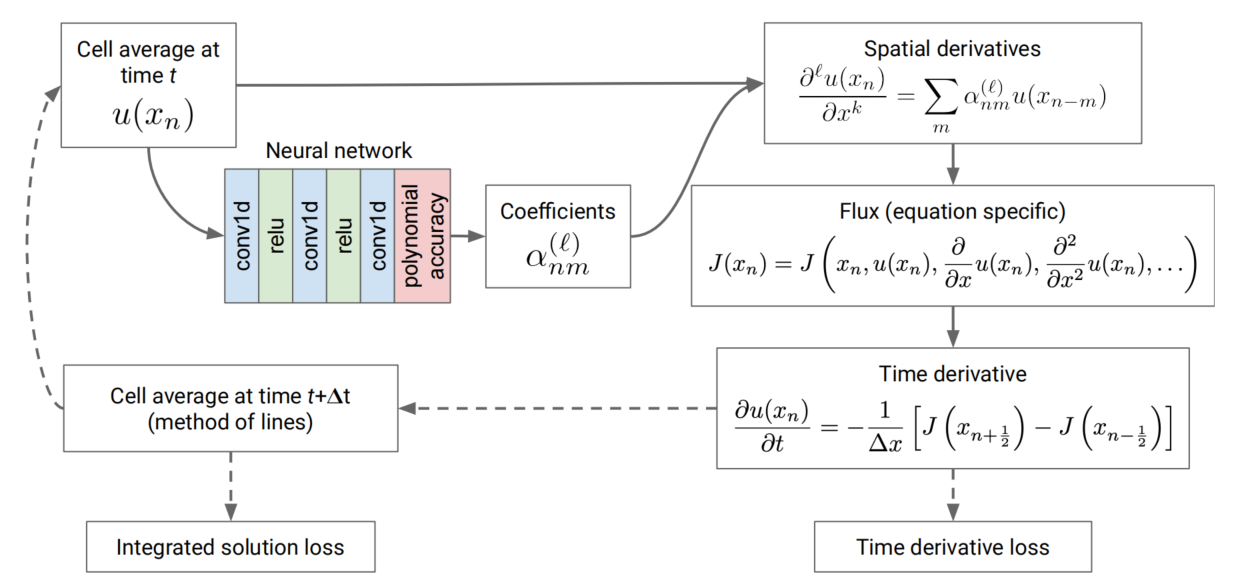



This neural network model has three fully convolutional layers, each with 32 filters of a fixed kernel of size five and with a ReLU nonlinearity between each layer. It's predictions at a single point are dependent on values of the local solution over a maximum range of 13 grid cells, which are independent of the model resolution. <br>
The coarse-grained function values are fed into this neural network. The network’s output, the coefficients $\alpha_i^{(n)}$, are combined with the coarse-grained values to estimate the spatial derivatives. These derivatives are used in the known physical equation for the flux, which we use to calculate the temporal derivative with a first-order divergence. The training minimizes either the difference between the calculated time derivative and the true one or the difference between the calculated evolved state at future times and the true evolved state. <br>
The models are trained using the Adam optimizer for 4000 steps total. The learning rate decreases by a factor of 10 after roughly half of steps. For most models, we first set an initial learning rate. Then, a certain batch size, which is a multiple of the resampling factor is used. 


## Implementation: Reproducing results



Notes on implementation code:

The following codes are derived from the notebook developed by Dr. Michael Brenner, which can be found here: https://github.com/google/data-driven-discretization-1d
along with the packages required for running this notebook.

For the programming environment, please run this final project notebook on Google Colab, which has all the required environment set up in advance. [final project on Colab](https://colab.research.google.com/drive/1jKILkbKR-fhqFnItlA8wKRgDNQNNPN6E?usp=sharing)

Backup URL in case hyperlink fails:
https://colab.research.google.com/drive/1jKILkbKR-fhqFnItlA8wKRgDNQNNPN6E?usp=sharing

Specifically, this notebook requires tensorflow 1, which is not supported on Python 3.7 and up, and thus running the program on a local computer would be difficult. 

### Setup environment

Specifically for this program to run, it requires some packages on GitHub and matplotlib version 3.1.3

In [ ]:
! pip install matplotlib==3.1.3
#! pip install -q -U xarray matplotlib
! rm -rf data-driven-discretization-1d
! git clone https://github.com/google/data-driven-discretization-1d.git
! pip install -e data-driven-discretization-1d
# install the seaborn bug-fix from https://github.com/mwaskom/seaborn/pull/1602
! pip install -U -q git+git://github.com/stfnrpplngr/seaborn.git@309a9de383fac4db1c66dbf87815c4ba0c439c59


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Cloning into 'data-driven-discretization-1d'...
remote: Enumerating objects: 352, done.
remote: Total 352 (delta 0), reused 0 (delta 0), pack-reused 352
Receiving objects: 100% (352/352), 714.43 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Obtaining file:///content/data-driven-discretization-1d
  Running setup.py develop for pde-superresolution
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [ ]:
# Ensure we're using Tensorflow 1.x in Colab. 
%tensorflow_version 1.x
import tensorflow as tf
assert tf.__version__[:2] == '1.'

import seaborn
assert seaborn.__version__ == '0.9.0', 'restart kernel after running previous cell'
from matplotlib.colors import LogNorm

import enum
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys, time, os, h5py

import os
import json
import numpy as np
import seaborn
import pandas as pd
import xarray
import matplotlib.pyplot as plt




# copy the pde directory to import pde
! cp -r ./data-driven-discretization-1d/pde_superresolution .

import pde_superresolution.utils
import pde_superresolution as pde

TensorFlow 1.x selected.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







### Dataset and model generation

Generate the dataset

In [ ]:

def _stack_all_rolls(inputs: tf.Tensor, max_offset: int) -> tf.Tensor:
  """Stack together all rolls of inputs, from 0 to max_offset."""
  rolled = [tf.concat([inputs[i:, ...], inputs[:i, ...]], axis=0)
            for i in range(max_offset)]
  return tf.stack(rolled, axis=0)


@enum.unique
class Dataset(enum.Enum):
  TRAINING = 0
  VALIDATION = 1


def _model_inputs(fine_inputs, resample_factor):
  inputs = fine_inputs[:, resample_factor-1::resample_factor]

  labels = tf.stack([fine_inputs[:, offset-1::resample_factor]
                     for offset in range(1, resample_factor)], axis=-1)

  base_grid = pde.polynomials.regular_grid(
      pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
      accuracy_order=hparams.coefficient_grid_min_size, dx=1)
  baselines = []
  for offset in range(1, hparams.resample_factor):
    current_grid = base_grid + 0.5 - offset / hparams.resample_factor
    method = pde.polynomials.Method.FINITE_DIFFERENCES
    reconstruction = pde.polynomials.reconstruct(
        inputs, current_grid, method, derivative_order=0)
    baselines.append(reconstruction)
  baseline = tf.stack(baselines, axis=-1)

  results = {'inputs': inputs, 'labels': labels, 'baseline': baseline}

  for accuracy_order in [1, 3, 5]:
    base_grid = pde.polynomials.regular_grid(
        pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
        accuracy_order=accuracy_order, dx=1)
    baselines = []
    for offset in range(1, hparams.resample_factor):
      current_grid = base_grid + 0.5 - offset / hparams.resample_factor
      method = pde.polynomials.Method.FINITE_DIFFERENCES
      reconstruction = pde.polynomials.reconstruct(
          inputs, current_grid, method, derivative_order=0)
      baselines.append(reconstruction)
    results[f'baseline_{accuracy_order}'] = tf.stack(baselines, axis=-1)

  return results


def make_dataset(snapshots,
                 hparams,
                 dataset_type: Dataset = Dataset.TRAINING,
                 repeat: bool = True,
                 evaluation: bool = False) -> tf.data.Dataset:
  snapshots = np.asarray(snapshots, dtype=np.float32)

  num_training = int(round(snapshots.shape[0] * hparams.frac_training))
  if dataset_type is Dataset.TRAINING:
    indexer = slice(None, num_training)
  else:
    assert dataset_type is Dataset.VALIDATION
    indexer = slice(num_training, None)

  dataset = tf.data.Dataset.from_tensor_slices(snapshots[indexer])
  rolls_stop = 1 if evaluation else hparams.resample_factor
  dataset = dataset.map(lambda x: _stack_all_rolls(x, rolls_stop))
  dataset = dataset.map(lambda x: _model_inputs(x, hparams.resample_factor))
  dataset = dataset.apply(tf.data.experimental.unbatch())
  dataset = dataset.cache()

  if repeat:
    dataset = dataset.apply(
        tf.data.experimental.shuffle_and_repeat(buffer_size=10000))

  batch_size = hparams.base_batch_size * hparams.resample_factor
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=1)
  return dataset


def stack_reconstruction(inputs, predictions):
  if isinstance(inputs, tf.Tensor):
    stacked = tf.concat([predictions, inputs[..., tf.newaxis], ], axis=-1)
    return tf.layers.flatten(stacked)
  else:
    stacked = np.concatenate([predictions, inputs[..., np.newaxis]], axis=-1)
    new_shape = stacked.shape[:-2] + (np.prod(stacked.shape[-2:]),)
    return stacked.reshape(new_shape)

Generate the model

In [ ]:
def predict_coefficients(inputs: tf.Tensor,
                         hparams: tf.contrib.training.HParams,
                         reuse: object =  tf.compat.v1.AUTO_REUSE) -> tf.Tensor:
  _, equation = pde.equations.from_hparams(hparams)
  pde.model.assert_consistent_solution(equation, inputs)

  with tf.variable_scope('predict_coefficients', reuse=reuse):
    num_derivatives = len(equation.DERIVATIVE_ORDERS)

    base_grid = pde.polynomials.regular_grid(
        pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
        accuracy_order=hparams.coefficient_grid_min_size,
        dx=1.0)

    net = inputs[:, :, tf.newaxis]
    net /= equation.standard_deviation

    activation = pde.model._NONLINEARITIES[hparams.nonlinearity]

    for _ in range(hparams.num_layers - 1):
      net = pde.layers.conv1d_periodic_layer(net, filters=hparams.filter_size,
                                         kernel_size=hparams.kernel_size,
                                         activation=activation, center=True)

    poly_accuracy_layers = []
    for offset in range(1, hparams.resample_factor):
      current_grid = base_grid + 0.5 - offset / hparams.resample_factor
      method = pde.polynomials.Method.FINITE_DIFFERENCES
      poly_accuracy_layers.append(
          pde.polynomials.PolynomialAccuracyLayer(
              grid=current_grid,
              method=method,
              derivative_order=0,
              accuracy_order=hparams.polynomial_accuracy_order,
              out_scale=hparams.polynomial_accuracy_scale)
      )
    input_sizes = [layer.input_size for layer in poly_accuracy_layers]

    if hparams.num_layers > 0:
      net = pde.layers.conv1d_periodic_layer(net, filters=sum(input_sizes),
                                          kernel_size=hparams.kernel_size,
                                          activation=None, center=True)
    else:
      initializer = tf.initializers.zeros()
      coefficients = tf.get_variable(
          'coefficients', (sum(input_sizes),),
          initializer=initializer)
      net = tf.tile(coefficients[tf.newaxis, tf.newaxis, :],
                    [tf.shape(inputs)[0], inputs.shape[1].value, 1])

    cum_sizes = np.cumsum(input_sizes)
    starts = [0] + cum_sizes[:-1].tolist()
    stops = cum_sizes.tolist()
    zipped = zip(starts, stops, poly_accuracy_layers)

    outputs = tf.stack([layer.apply(net[..., start:stop])
                        for start, stop, layer in zipped], axis=-2)
    assert outputs.shape.as_list()[-1] == base_grid.size

    return outputs


def predict(inputs, hparams):
  coefficients = predict_coefficients(inputs, hparams)
  return pde.model.apply_coefficients(coefficients, inputs)


def setup_training(dataset, hparams, scale=1.0):
  tensors = dataset.make_one_shot_iterator().get_next()
  predictions = predict(tensors['inputs'], hparams)
  loss = tf.reduce_mean((tensors['labels'] - predictions) ** 2) / scale
  train_step = pde.training.create_training_step(loss, hparams)
  return loss, train_step


def baseline_loss(snapshots, hparams):
  dataset = make_dataset(snapshots, hparams, repeat=False, evaluation=True)

  tensors = dataset.make_one_shot_iterator().get_next()
  loss = tf.reduce_mean((tensors['labels'] - tensors['baseline_1']) ** 2)

  sess = tf.Session(config=pde.training._session_config())
  losses = []
  while True:
    try:
      losses.append(sess.run(loss))
    except tf.errors.OutOfRangeError:
      break
  return np.mean(losses)

### Import initialization data

The following data from GitHub needs to be imported before the tensorflow model can execute.

In [ ]:
! gsutil cp gs://data-driven-discretization-public/training-data/burgers.h5 .

Copying gs://data-driven-discretization-public/training-data/burgers.h5...
/ [1 files][ 39.1 MiB/ 39.1 MiB]                                                
Operation completed over 1 objects/39.1 MiB.                                     


In [ ]:
with h5py.File('burgers.h5') as f:
  snapshots = f['v'][...]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


### Visualize an example

Set up parameters for the tensorflow model

In [ ]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=16,
    equation_kwargs=json.dumps(dict(num_points=512)),
    base_batch_size=32,
)

#### Baseline performance (no machine learning, pure numerical)

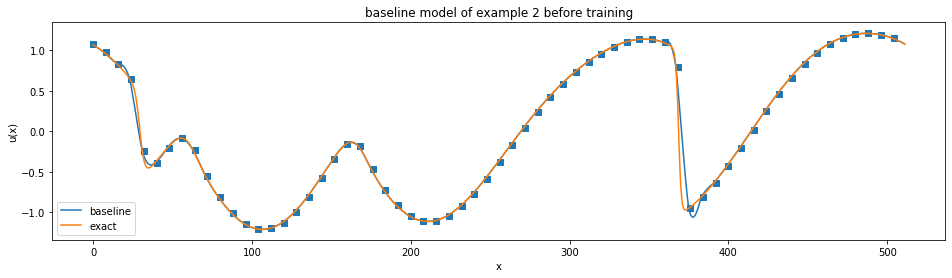

In [ ]:
demo_dataset = make_dataset(snapshots, hparams, repeat=False, evaluation=True)

sess = tf.Session(config=pde.training._session_config())
tf_example = demo_dataset.make_one_shot_iterator().get_next()
example = sess.run(tf_example)

plt.figure(figsize=(16, 4))
example_id = 2
plt.scatter(np.arange(0, 512, hparams.resample_factor),
            np.roll(example['inputs'][example_id], 1, axis=-1), marker='s')
plt.plot(stack_reconstruction(example['inputs'], example['baseline'])[example_id], label='baseline')
plt.plot(stack_reconstruction(example['inputs'], example['labels'])[example_id], label='exact')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("baseline model of example {} before training".format(example_id))
plt.legend()

#### Untrained model

Test performance of model predictions before training, for reference and comparison against trained models in following sections

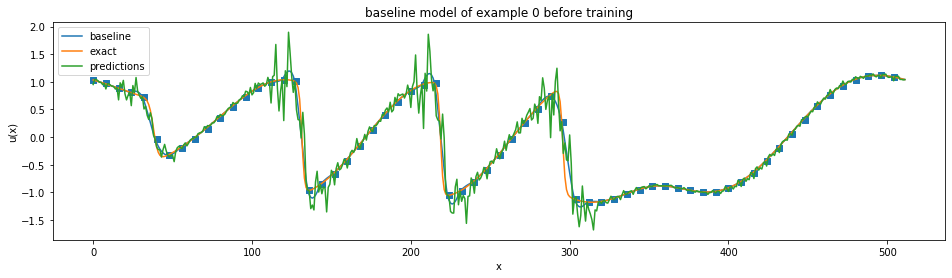

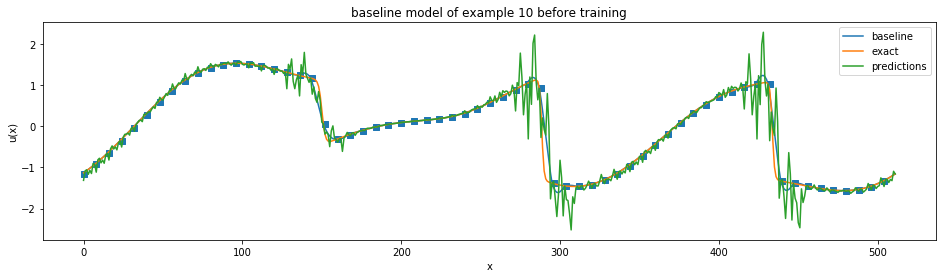

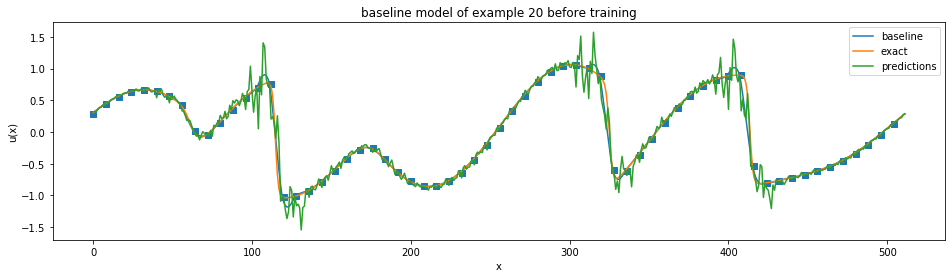

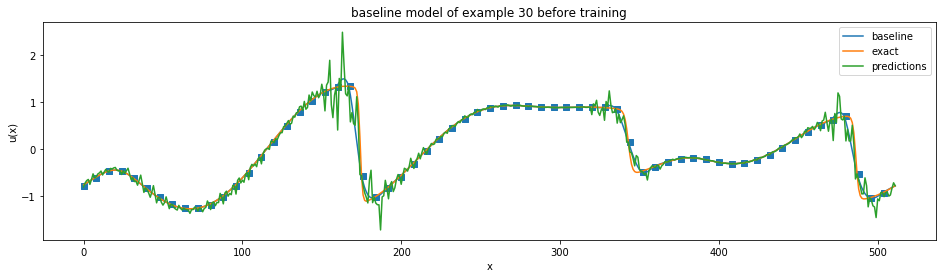

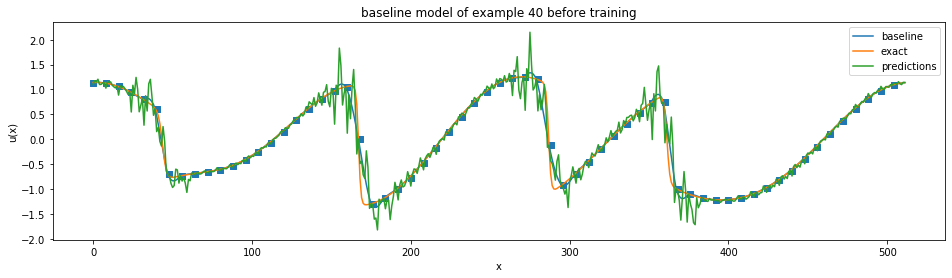

In [ ]:
demo_dataset = make_dataset(snapshots, hparams, Dataset.VALIDATION, repeat=False, evaluation=True)

tensors = demo_dataset.make_one_shot_iterator().get_next()
tensors['predictions'] = predict(tensors['inputs'], hparams)
sess.run(tf.global_variables_initializer())
example = sess.run(tensors)

for example_id in [0, 10, 20, 30, 40]:
  plt.figure(figsize=(16, 4))
  plt.scatter(np.arange(0, 512, hparams.resample_factor),
              np.roll(example['inputs'][example_id], 1, axis=-1), marker='s')
  plt.plot(stack_reconstruction(example['inputs'], example['baseline'])[example_id], label='baseline')
  plt.plot(stack_reconstruction(example['inputs'], example['labels'])[example_id], label='exact')
  plt.plot(stack_reconstruction(example['inputs'], example['predictions'])[example_id], label='predictions')
  plt.xlabel("x")
  plt.ylabel("u(x)")
  plt.title("baseline model of example {} before training".format(example_id))
  plt.legend()

## Implementation: Parallelization

### Parallelization setup


Set up training parameters

In [ ]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=8,
    equation_kwargs=json.dumps(dict(num_points=512)),
    eval_interval=50,
    learning_stops=[2000, 4000],
    learning_rates=[3e-3, 3e-4],
    
)
loss_scale = baseline_loss(snapshots, hparams)

Initialize training process

In [ ]:
%%time
tf.reset_default_graph()
dataset = make_dataset(snapshots, hparams)
loss, train_step = setup_training(dataset, hparams, scale=loss_scale)

sess = tf.Session(config=pde.training._session_config())
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 1.5 s, sys: 40.6 ms, total: 1.54 s
Wall time: 1.65 s


### Begin parallelization and training

Define the function to be parallelized

In [ ]:
# define function as parallel computing target
# import multiprocessing 
from joblib import Parallel, delayed
import time

def mp_fun(i):
    sess.run(train_step)
    if (i + 1) % hparams.eval_interval == 0:
        print(i, sess.run(loss))
        loss_arr[i] = sess.run(loss)

Parallelized for loop using shared memory and joblib package

**Note: running the below code block takes approximately 20 minutes with stardard Google Colab engine.**

In [ ]:
%%time
loss_arr = np.zeros((hparams.learning_stops[-1]))
result = Parallel(n_jobs=8, backend="threading", require='sharedmem')(delayed(mp_fun)(i) 
        for i in range(hparams.learning_stops[-1]))
loss_arr_p = loss_arr

49 0.27877566
99 0.64624333
149 0.5853861
199 0.479074
249 0.50988555
299 0.5375812
349 0.57732487
399 0.37961605
449 0.26061693
499 0.2998782
549 0.42017102
599 0.29026386
649 0.8394036
699 0.27620435
749 0.16338739
799 0.23842485
849 0.3000593
899 0.34432688
949 0.20557192
999 0.17438114
1049 0.25433716
1099 0.3632755
1149 0.1525687
1199 0.2784347
1249 0.29554537
1299 0.20015953
1349 0.15150599
1399 0.16764405
1449 0.21431682
1499 0.11670792
1549 0.22311758
1599 0.20348139
1649 0.11600057
1699 0.112973765
1749 0.12016639
1799 0.12280416
1849 0.12557153
1899 0.12743016
1949 0.12369231
1999 0.15471213
2049 0.07674245
2099 0.06794664
2149 0.06898404
2199 0.06244115
2249 0.06682776
2299 0.06392085
2349 0.06437786
2399 0.05238594
2449 0.056267884
2499 0.05949566
2549 0.05518918
2599 0.060637172
2649 0.052622046
2699 0.05078141
2749 0.053423
2799 0.046688322
2849 0.05109161
2899 0.046576366
2949 0.044959623
2999 0.045634255
3049 0.045946617
3099 0.04553786
3149 0.04725979
3199 0.052564576


## Implementation: results

### Dataset from trained model

In [ ]:
demo_dataset = make_dataset(snapshots, hparams, Dataset.VALIDATION, repeat=False, evaluation=True)

tensors = demo_dataset.make_one_shot_iterator().get_next()
tensors['predictions'] = predict(tensors['inputs'], hparams)

array_list = []
while True:
  try:
    array_list.append(sess.run(tensors))
  except tf.errors.OutOfRangeError:
    break
arrays = {k: np.concatenate([d[k] for d in array_list])
          for k in array_list[0]}

In [ ]:
ds_t = xarray.Dataset({
    'inputs': (('sample', 'x'), arrays['inputs']),
    'labels': (('sample', 'x', 'offset'), arrays['labels']),
    'nn_predictions': (('sample', 'x', 'offset'), arrays['predictions']),
    'poly_predictions': (('sample', 'x', 'accuracy_order', 'offset'),
                          np.stack([arrays['baseline_1'],arrays['baseline_3'], arrays['baseline_5']], axis=-2)),
}, coords={'accuracy_order': [1, 3, 5]})

In [ ]:
ds_t

<xarray.Dataset>
Dimensions:           (sample: 2000, x: 64, offset: 7, accuracy_order: 3)
Coordinates:
  * accuracy_order    (accuracy_order) int64 1 3 5
Dimensions without coordinates: sample, x, offset
Data variables:
    inputs            (sample, x) float32 0.9711 0.8941 ... -0.2659 -0.08285
    labels            (sample, x, offset) float32 1.033 1.024 ... -0.1064
    nn_predictions    (sample, x, offset) float32 1.034 1.026 ... -0.136 -0.1061
    poly_predictions  (sample, x, accuracy_order, offset) float32 1.032 ... -...

Plot solutions for some examples

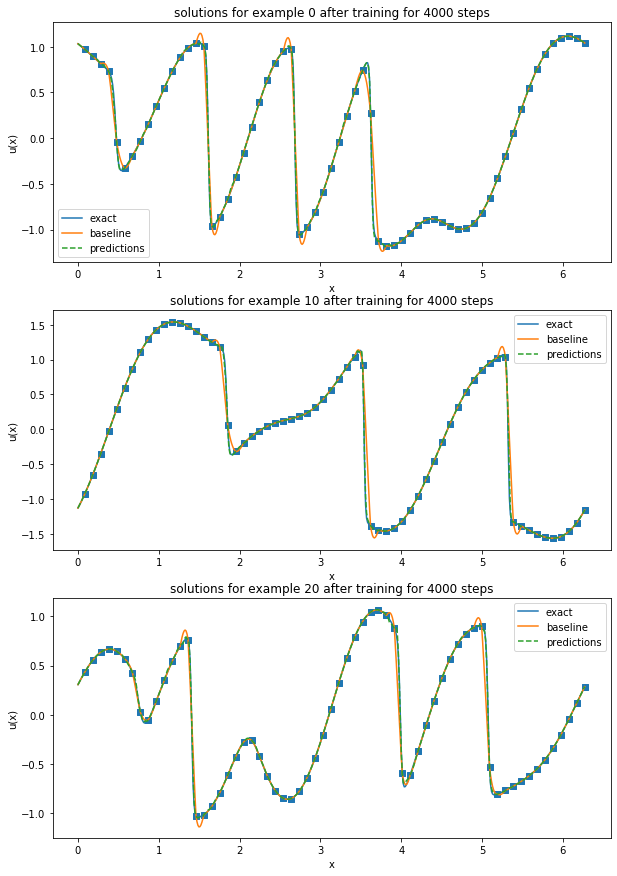

In [ ]:
example_id = 0
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
x = np.arange(512) * 2 * np.pi / 512
colors = seaborn.color_palette(n_colors=3)

for ax, example_id in zip(axes.ravel(), [0, 10, 20]):
  ax.scatter(x[hparams.resample_factor-1::hparams.resample_factor],
             ds_t.inputs.data[example_id],
             marker='s',  color=colors[0])
  ax.plot(x, stack_reconstruction(ds_t.inputs.data, ds_t.labels.data)[example_id],
          label='exact', color=colors[0])
  ax.plot(x, stack_reconstruction(ds_t.inputs.data, ds_t.poly_predictions.sel(accuracy_order=3).data)[example_id],
          label='baseline', color=colors[1])
  ax.plot(x, stack_reconstruction(ds_t.inputs.data, ds_t.nn_predictions.data)[example_id],
          label='predictions', linestyle='--', color=colors[2])
  ax.set_xlabel("x")
  ax.set_ylabel("u(x)")
  ax.set_title("solutions for example {} after training for 4000 steps".format(example_id))
  ax.legend()

Compared to the performace of the model before training, it can be concluded that training has succeeded.

Please refer to the above section **"Untrained model."**

### Dataset from imported data

This section below imports results from a previous run, which is not related to my own parallelized training process.

In [ ]:
!gsutil cp gs://data-driven-discretization-public/reconstruction/burgers_results_8x.nc .

Copying gs://data-driven-discretization-public/reconstruction/burgers_results_8x.nc...
\ [1 files][ 17.6 MiB/ 17.6 MiB]                                                
Operation completed over 1 objects/17.6 MiB.                                     


In [ ]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=8,
    equation_kwargs=json.dumps(dict(num_points=512)),
    eval_interval=500,
    learning_stops=[20000, 40000],
    learning_rates=[3e-3, 3e-4],
)

In [ ]:
ds = xarray.open_dataset('burgers_results_8x.nc').load()

In [ ]:
ds

<xarray.Dataset>
Dimensions:           (sample: 2000, x: 64, offset: 7, accuracy_order: 3)
Coordinates:
  * accuracy_order    (accuracy_order) int32 1 3 5
Dimensions without coordinates: sample, x, offset
Data variables:
    labels            (sample, x, offset) float32 1.033 1.024 ... -0.1064
    nn_predictions    (sample, x, offset) float32 1.033 1.025 ... -0.1065
    poly_predictions  (sample, x, accuracy_order, offset) float32 1.032 ... -...
    inputs            (sample, x) float32 0.9711 0.8941 ... -0.2659 -0.08285

The model is expected to achieve 3-rd order accuracy after training for 40000 steps.

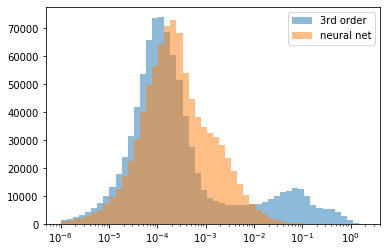

In [ ]:
plt.hist(abs(ds.labels - ds.poly_predictions.sel(accuracy_order=3)).data.ravel(),
         bins=np.geomspace(1e-6, 2, num=51), alpha=0.5, label='3rd order');
plt.hist(abs(ds.labels - ds.nn_predictions).data.ravel(),
         bins=np.geomspace(1e-6, 2, num=51), alpha=0.5, label='neural net');
plt.xscale('log')
plt.legend()

plot solutions for some examples

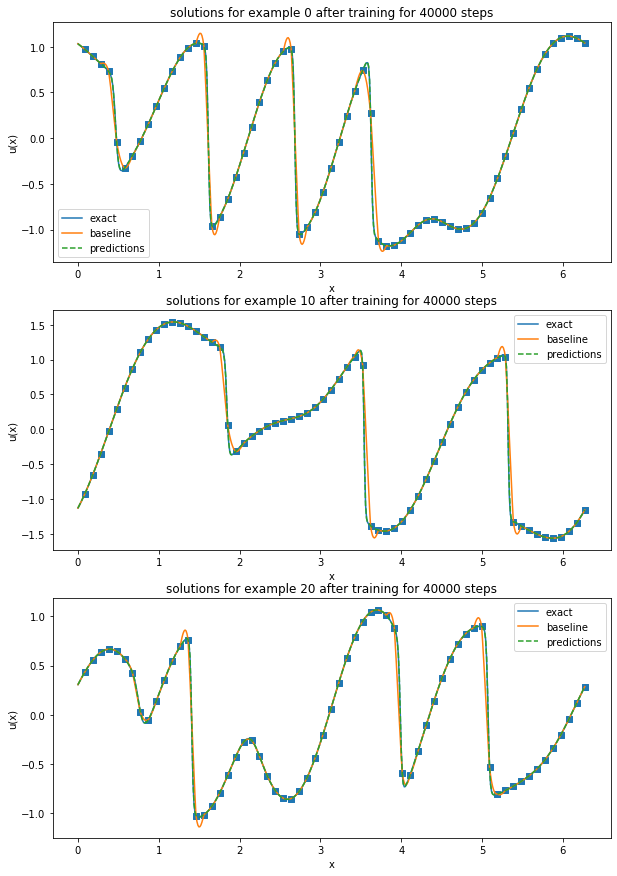

In [ ]:
example_id = 0
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
x = np.arange(512) * 2 * np.pi / 512
colors = seaborn.color_palette(n_colors=3)

for ax, example_id in zip(axes.ravel(), [0, 10, 20]):
  ax.scatter(x[hparams.resample_factor-1::hparams.resample_factor],
             ds.inputs.data[example_id],
             marker='s',  color=colors[0])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.labels.data)[example_id],
          label='exact', color=colors[0])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.poly_predictions.sel(accuracy_order=3).data)[example_id],
          label='baseline', color=colors[1])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.nn_predictions.data)[example_id],
          label='predictions', linestyle='--', color=colors[2])
  ax.set_xlabel("x")
  ax.set_ylabel("u(x)")
  ax.set_title("solutions for example {} after training for 40000 steps".format(example_id))
  ax.legend()

### Loss convergence analysis

Re-initialize training model

In [ ]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=8,
    equation_kwargs=json.dumps(dict(num_points=512)),
    eval_interval=50,
    learning_stops=[2000, 4000],
    learning_rates=[3e-3, 3e-4],
    
)
loss_scale = baseline_loss(snapshots, hparams)

Start new session of tensorflow

In [ ]:
%%time
tf.reset_default_graph()
dataset = make_dataset(snapshots, hparams)
loss, train_step = setup_training(dataset, hparams, scale=loss_scale)

sess = tf.Session(config=pde.training._session_config())
sess.run(tf.global_variables_initializer())

CPU times: user 1.47 s, sys: 50 ms, total: 1.52 s
Wall time: 1.52 s


Serial code for training the model

**Note: runtime is approximately 20 minutes**

In [ ]:
%%time
loss_arr = np.zeros((hparams.learning_stops[-1]))
for step in range(hparams.learning_stops[-1]):
    mp_fun(step)
loss_arr_s = loss_arr


49 0.25706655
99 0.1442888
149 0.107274644
199 0.0809428
249 0.08259413
299 0.056999296
349 0.05950808
399 0.046043973
449 0.043461308
499 0.041715577
549 0.039219793
599 0.037676834
649 0.04140145
699 0.033088643
749 0.0332921
799 0.032596245
849 0.03088315
899 0.029292736
949 0.026342928
999 0.025213255
1049 0.025552431
1099 0.02859163
1149 0.020355755
1199 0.026359977
1249 0.02025784
1299 0.01888157
1349 0.02795914
1399 0.018199883
1449 0.020975206
1499 0.019834615
1549 0.02910598
1599 0.018451393
1649 0.017205276
1699 0.021029348
1749 0.019462304
1799 0.01909258
1849 0.01784295
1899 0.023877425
1949 0.021836502
1999 0.013468197
2049 0.015357618
2099 0.012262034
2149 0.016608423
2199 0.014998417
2249 0.014574977
2299 0.014699045
2349 0.014158593
2399 0.012506035
2449 0.014915456
2499 0.011524848
2549 0.013688412
2599 0.014521545
2649 0.014603531
2699 0.013735108
2749 0.016024094
2799 0.012696509
2849 0.011390204
2899 0.013800484
2949 0.013103906
2999 0.013594511
3049 0.011095485
309

Plot parallel and serial loss convergence

Text(0.5, 1.0, 'loss vs steps with serial training')

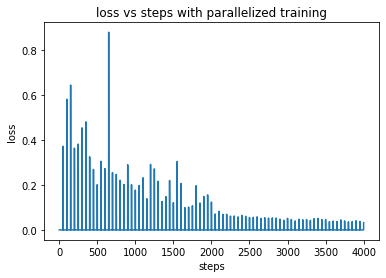

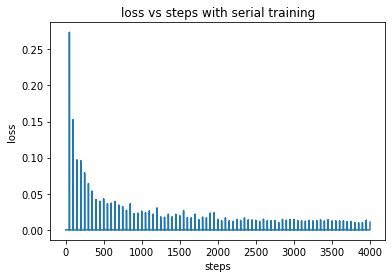

In [ ]:
x_axis = np.linspace(1,4000,4000)
plt.plot(x_axis, loss_arr_p)
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("loss vs steps with parallelized training")

plt.figure()
plt.plot(x_axis, loss_arr_s)
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("loss vs steps with serial training")

Comparing the parallelized code and the serial code, it is unclear whether parallelization has reduced runtime to a significant level. Serial code runtime is slightly longer than parallelized code (reference code provided in the next section). Also note that these two outputs came from a reduced training size (4000) compared to the original training size of 40000. 

It appears that the parallelized training process converges slower than the serial process. However, given a specific tolerance, it can be argued that both methods will converge. 



 ## Numerical analysis

To train the network, we generate a set of high-resolution solutions to the equation, sampled at regular time intervals from some numerical integrations. To obtain high accuracy solutions to Burgers’ equation on a fully resolved grid, we use a fifth-order WENO method and 512 grids points. For KdV and KS, we use a pseudo-spectral method for numerical differentiation, which is more accurate than Finite Volumes, with 256 grid points. For calculating the loss during training, we use third-order Finite Volumes on the spectral method’s solution to calculate spatial derivatives. 

For numerical time integration to produce training and evaluation datasets, we use an explicit Runge-Kutta method of order 3 with adaptive time-stepping, as implemented in the SciPy package. For time integration during the training procedure itself, we use the midpoint method with a fixed time-step of 0.001 for Burgers’ equation, based on the minimum time-step on the high resolution grid chosen by adaptive time-stepping. We use these methods due to their robustness and simplicity, although they are not optimized time integration methods for these equations. For example, a practical method for the viscous Burgers’ equation should use implicit time-stepping, because the diffusive term limits the maximum stable explicit time step to be smaller than the square of the grid spacing. 

In order to analyze our parallelization, we need to note that the precomputed coefficients for derivative equations are generated by iteration. That is, we send the output of our neural network into the network as the input over and over again. We call each iteration a step. What we had paralleled in our code are precisely those steps. The general idea is similar to openMP we studied in class, only that the workload balancing is done for us by the python parallelization library. We fork our program into many threads, and then each of these threads is responsible for a number of steps. The issue, however, is obvious: the connection between different threads is not clear and we have no way to establish or control it. Therefore, there must have been some sort of error produced in the process. It is shown by the rebounce, or sudden increase in magnitude, of error in the series of iteration output of error, which has a general decreasing trend. However, due to unknown reasons, despite this issue, our algorithm converges nevertheless. 

To perform a scalability analysis, we begin by noting that we first use machine learning to generate the precomputed coefficients $\alpha_i$ to construct the derivative equations used for numerical iteration, which produces our calculated results. Therefore, our parallelization improves the speed of the training process whereas the later numerical integration process is unchanged. Thus, from the output of our code above, we do not have a significant improvement on the total run time due to the fact that the bulk of the computation done is still the unchanged numerical integration. However, because of our improved training process, our scalability analysis is that our newly invented method improves the original algorithm by increasing its rate of convergence. 

## Conclusions

The training process of the machine learning model for solving PDE's can be parallelized. However, parallelization does not save significant runtime, and the errors converge at a generally slower rate. Therefore, in the current situation, it is not optimal to parallelize the training of the model. 

In the next section, more details will be discussed on the results of this project, and possible solutions for the problem will be discussed.

## Future studies

First, we will investigate further into the details of our neural network and find out why does our algorithm still converges, even when the steps are separated with no consideration of how those thread communicate their individual result between each other. We can also study the rebounce of errors to find out the cause of it and why it does not affect the overall convergence. As an effort to make the first step, we could find inspiration in our 2-d jacobi mpi parallelization discussed in class, since in the jacobi problem, every process has overlapping points with the neighboring processes, which ensures that all the grids are in sync in terms of producing the correct result after each iteration. For our problem, we could devise a method of communication to precompute the initial input before the first iteration for each thread, thus achieving that the iteration results can be put together to form a serial output while the work is paralleled. 

Second, although we can only apply shared memory parallelization as of now, we will nevertheless delve deeper into python parallelization and find a way to really implement mpi, or any form of distributed memory parallelization, to both our machine learning network and our numerical PDE solving. We will probably implement hybrid parallelization as well. 

Third, we will take our project to a higher level by considering the 2-D case. That is, we will still train low-resolution models to learn the rules from their high-resolution counterparts. The learned models will be used to produce high-fidelity simulations using much fewer computational resources. The algorithm of this project is equation-specific and requires training a coarse resolution solver with high-resolution ground-truth simulations. We hope to extend this method to the two-dimensional advection of passive scalars in a turbulent flow. We want to show that machine-learned advection solvers can use a grid with much coarser resolution than classic high-order solvers while still maintaining the same accuracy. 

## Reference

Bar-Sinai, Yohai et al. “Data-driven discretization: machine learning for coarse graining of partial differential equations.” (2018). 

Beck, Andrea D. et al. “Deep Neural Networks for Data-Driven Turbulence Models.” J. Comput. Phys. 398 (2019): n. pag.

Bézenac, Emmanuel de et al. “Deep Learning for Physical Processes: Incorporating Prior Scientific Knowledge.” ArXiv abs/1711.07970 (2018): n. pag.

Brunton, Steven L. et al. “Discovering governing equations from data by sparse identification of nonlinear dynamical systems.” Proceedings of the National Academy of Sciences 113 (2016): 3932 - 3937.

González-García, R. et al. “Identification of distributed parameter systems: A neural net based approach.” Computers & Chemical Engineering 22 (1998): 965-968.

Kevrekidis, Ioannis G. and Giovanni Samaey. “Equation-free multiscale computation: algorithms and applications.” Annual review of physical chemistry 60 (2009): 321-44.

Kim, Byungsoo et al. “Deep Fluids: A Generative Network for Parameterized Fluid Simulations.” Computer Graphics Forum 38 (2019): n. pag. 

Lusch, Bethany et al. “Deep learning for universal linear embeddings of nonlinear dynamics.” Nature Communications 9 (2018): n. pag. 

Morton, Jeremy et al. “Deep Dynamical Modeling and Control of Unsteady Fluid Flows.” ArXiv abs/1805.07472 (2018): n. pag. 

Rasp, Stephan et al. “Deep learning to represent subgrid processes in climate models.” Proceedings of the National Academy of Sciences of the United States of America 115 (2018): 9684 - 9689.

Roberts, Anthony J.. “Holistic discretization ensures fidelity to Burgers' equation.” Applied Numerical Mathematics 37 (2001): 371-396.

Tompson, Jonathan et al. “Accelerating Eulerian Fluid Simulation With Convolutional Networks.” ArXiv abs/1607.03597 (2017): n. pag. 
